In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split, Dataset
import time
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import pandas as pd
import os

Configuration & Setup

In [3]:
data_dir = r'food-101-resized' 

BATCH_SIZE = 128        # ถ้า GPU Memory เต็ม ให้ลดเหลือ 16 หรือ 8
NUM_EPOCHS = 20        # จำนวนรอบสูงสุด (มี Early Stopping ช่วยหยุดก่อนได้)
LEARNING_RATE = 0.001
PATIENCE = 5           # ถ้านิ่ง 5 รอบให้หยุด (Early Stopping)

# ตรวจสอบ GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔹 Using device: {device}")

🔹 Using device: cuda


Custom Dataset Class

In [6]:
class MapDataset(Dataset):
    """
    Class นี้ช่วยให้เรา map transform ที่แตกต่างกันให้กับ
    subset ที่ถูกแบ่งมาจาก dataset ก้อนเดียวกัน
    """
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.dataset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.dataset)

Data Transforms (Augmentation)

In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(p = 0.5),
    #transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Val/Test: ห้ามปรุงแต่งภาพ แค่ปรับขนาด
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
import io
from PIL import Image
from tqdm import tqdm # ใช้แสดงหลอดโหลด

# ==========================================
# 1. เพิ่ม Class นี้ลงไป (แทนที่ Dataset เดิม)
# ==========================================
class InMemoryJPEGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.samples = []
        
        # ใช้ ImageFolder เพื่อช่วยสแกนหา Path รูปและชื่อ Class
        print(f"🔍 Scanning files in {root_dir}...")
        temp_dataset = datasets.ImageFolder(root_dir)
        self.classes = temp_dataset.classes
        
        print(f"🚀 Loading {len(temp_dataset)} images into RAM (32GB is plenty!)...")
        
        # วนลูปอ่านไฟล์ทีละรูป เก็บเป็น Byte (ประหยัดแรมกว่าเก็บเป็นภาพ)
        for path, label in tqdm(temp_dataset.samples):
            with open(path, 'rb') as f:
                img_bytes = f.read() # อ่านเป็นก้อนข้อมูลดิบ
                self.samples.append((img_bytes, label))
                
        print("✅ All images loaded to RAM! Disk I/O is now eliminated.")

    def __getitem__(self, index):
        img_bytes, label = self.samples[index]
        
        # แปลง Bytes กลับเป็นรูปภาพตอนจะใช้เท่านั้น (On-the-fly)
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')
        
        if self.transform:
            img = self.transform(img)
            
        return img, label

    def __len__(self):
        return len(self.samples)

Load & Split Data

In [9]:
def prepare_data(data_dir):
    print("\n🔹 Loading Data to RAM...")
    
    # *** เรียกใช้ Class ใหม่ที่สร้างไว้ ***
    full_dataset_ram = InMemoryJPEGDataset(data_dir) 
    
    class_names = full_dataset_ram.classes
    num_classes = len(class_names)
    
    # แบ่ง Train/Val/Test (Logic เดิม)
    total_len = len(full_dataset_ram)
    train_len = int(0.8 * total_len)
    val_len = int(0.1 * total_len)
    test_len = total_len - train_len - val_len

    # ใช้ dataset ก้อนใหญ่ใน RAM มาแบ่ง
    train_subset, val_subset, test_subset = random_split(
        full_dataset_ram, [train_len, val_len, test_len],
        generator=torch.Generator().manual_seed(42)
    )

    # Wrap ด้วย MapDataset เพื่อใส่ Transform (ใช้ Class MapDataset เดิมที่คุณมี)
    train_dataset = MapDataset(train_subset, train_transforms)
    val_dataset = MapDataset(val_subset, val_transforms)
    test_dataset = MapDataset(test_subset, val_transforms)

    # DataLoader
    # หมายเหตุ: เมื่อข้อมูลอยู่ใน RAM แล้ว num_workers=0 จะเร็วมากและเสถียรสุดบน Windows
    # แต่ถ้าอยากลองเร่ง สามารถลองเปลี่ยนเป็น 2 ได้ (แต่ 0 ก็เร็วเหลือเฟือแล้วครับกรณีนี้)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    print(f"   Split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")
    return train_loader, val_loader, test_loader, class_names, num_classes

Model Setup (Resnet-50 Transfer Learning)

In [ ]:
def build_model(num_classes):
    print("\n🔹 Building ResNet50 Model...")
    
    # 1. โหลด ResNet50 พร้อม Weights
    # (เปลี่ยนจาก VGG16_Weights เป็น ResNet50_Weights)
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    # 2. Freeze ทุก Layer ก่อน
    for param in model.parameters():
        param.requires_grad = False

    # 3. แก้ไข Layer สุดท้าย (ResNet ใช้ชื่อ .fc)
    # เราจะเปลี่ยน fc เดิม ให้เป็น Linear Layer ใหม่ที่รองรับ 101 Classes
    # (Layer ใหม่ที่สร้างขึ้นนี้ จะมี requires_grad = True โดยอัตโนมัติ)
    in_features = model.fc.in_features  # ปกติคือ 2048
    model.fc = nn.Linear(in_features, num_classes)

    model = model.to(device)
    return model

Training Function (Advanced)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience):
    start = time.time()
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    patience_counter = 0 
    
    # Scheduler: ลด LR ลงถ้า Loss ไม่ลดลง 3 รอบ
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

    print("\n🔹 Start Training...")
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Record history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                
                # Update Scheduler & Check Early Stopping
                scheduler.step(epoch_loss)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    torch.save(model.state_dict(), 'best_model_food101.pth') # Save ทันทีที่ดีที่สุด
                    print(f"   --> 💾 Saved new best model (Acc: {best_acc:.4f})")
                    patience_counter = 0
                else:
                    patience_counter += 1
        
        if patience_counter >= patience:
            print(f"\n⏹ Early Stopping triggered at epoch {epoch+1}!")
            break

    time_elapsed = time.time() - start
    print(f'\n✅ Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best Val Acc: {best_acc:4f}')

    # Load best weights before returning
    model.load_state_dict(best_model_wts)
    return model, history

Evaluation & Visualization

In [ ]:
def evaluate_and_plot(model, history, test_loader, class_names):
    print("\n🔹 Starting Evaluation...")
    
    # 1. Plot Training History
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Acc')
    plt.plot(epochs_range, val_acc, label='Validation Acc')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # 2. Test Set Evaluation
    print("   Generating predictions on Test Set...")
    y_pred = []
    y_true = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # 3. F1 Score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n📊 Weighted F1-Score: {f1:.4f}")
    
    # 4. Classification Report (แสดงแค่ 10 คลาสแรกถ้ามันยาวเกิน)
    print("\n📊 Classification Report (First 10 classes):")
    print(classification_report(y_true, y_pred, target_names=class_names, labels=range(10), digits=4))

    # 5. Confusion Matrix
    print("\n📊 Plotting Confusion Matrix...")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(24, 24)) # ขนาดใหญ่พิเศษสำหรับ 101 คลาส
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix: Food-101')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

In [11]:
train_loader, val_loader, test_loader, class_names, num_classes = prepare_data(data_dir)


🔹 Loading Data to RAM...
🔍 Scanning files in food-101-resized...
🚀 Loading 101000 images into RAM (32GB is plenty!)...


100%|██████████| 101000/101000 [10:20<00:00, 162.75it/s]

✅ All images loaded to RAM! Disk I/O is now eliminated.
   Split: Train=80800, Val=10100, Test=10100


In [ ]:
model = build_model(num_classes)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [ ]:
trained_model, history = train_model(
        model, 
        train_loader, 
        val_loader, 
        criterion, 
        optimizer, 
        num_epochs=NUM_EPOCHS, 
        patience=PATIENCE
    )

In [1]:
import torch
import torch.nn as nn
from torchvision import models

# 1. กำหนด Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. สร้างโครงร่างโมเดล (ต้องเหมือนตอนเทรนเป๊ะๆ)
# ตอนเทรนเราใช้ ResNet50 และแก้ fc เป็น 101 คลาส
model_eval = models.resnet50(weights=None) # ไม่ต้องโหลด weights imagenet แล้ว เพราะเดี๋ยวเราจะทับด้วยของเราเอง
num_ftrs = model_eval.fc.in_features
model_eval.fc = nn.Linear(num_ftrs, 101) # แก้ให้รองรับ 101 คลาส

# 3. โหลดไฟล์ .pth (Weights) ใส่เข้าไป
# *** แก้ชื่อไฟล์ตรงนี้ให้ตรงกับที่คุณเซฟไว้ ***
PATH = 'best_model_food101_Resnet.pth' 

if torch.cuda.is_available():
    state_dict = torch.load(PATH)
else:
    # กรณีรันบนเครื่องไม่มี GPU ต้อง map ไปที่ cpu
    state_dict = torch.load(PATH, map_location=torch.device('cpu'))

model_eval.load_state_dict(state_dict)

# 4. ย้ายไป GPU และตั้งเป็น Eval Mode
model_eval = model_eval.to(device)
model_eval.eval()

print("✅ Load Model สำเร็จ! พร้อมใช้งาน")

Using device: cuda


C:\Users\mikmi\AppData\Local\Temp\ipykernel_34532\1847502415.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(PATH)


✅ Load Model สำเร็จ! พร้อมใช้งาน


Generating predictions on Test Set...

📊 Weighted F1-Score: 0.5494

📊 Classification Report (First 10 classes):
                         precision    recall  f1-score   support

              apple_pie     0.4259    0.1901    0.2629       121
         baby_back_ribs     0.5446    0.5810    0.5622       105
                baklava     0.4950    0.4808    0.4878       104
         beef_carpaccio     0.5804    0.5462    0.5628       119
           beef_tartare     0.3226    0.3704    0.3448       108
             beet_salad     0.4034    0.4571    0.4286       105
               beignets     0.7034    0.7830    0.7411       106
               bibimbap     0.6522    0.6881    0.6696       109
          bread_pudding     0.3611    0.3277    0.3436       119
      breakfast_burrito     0.5663    0.4700    0.5137       100

              micro avg     0.5076    0.4845    0.4958      1096
              macro avg     0.5055    0.4894    0.4917      1096
           weighted avg     0.5034    0.4

d:\anaconda3\envs\dlenv\lib\site-packages\sklearn\metrics\_classification.py:2964: UserWarning: labels size, 10, does not match size of target_names, 101
  warnings.warn(


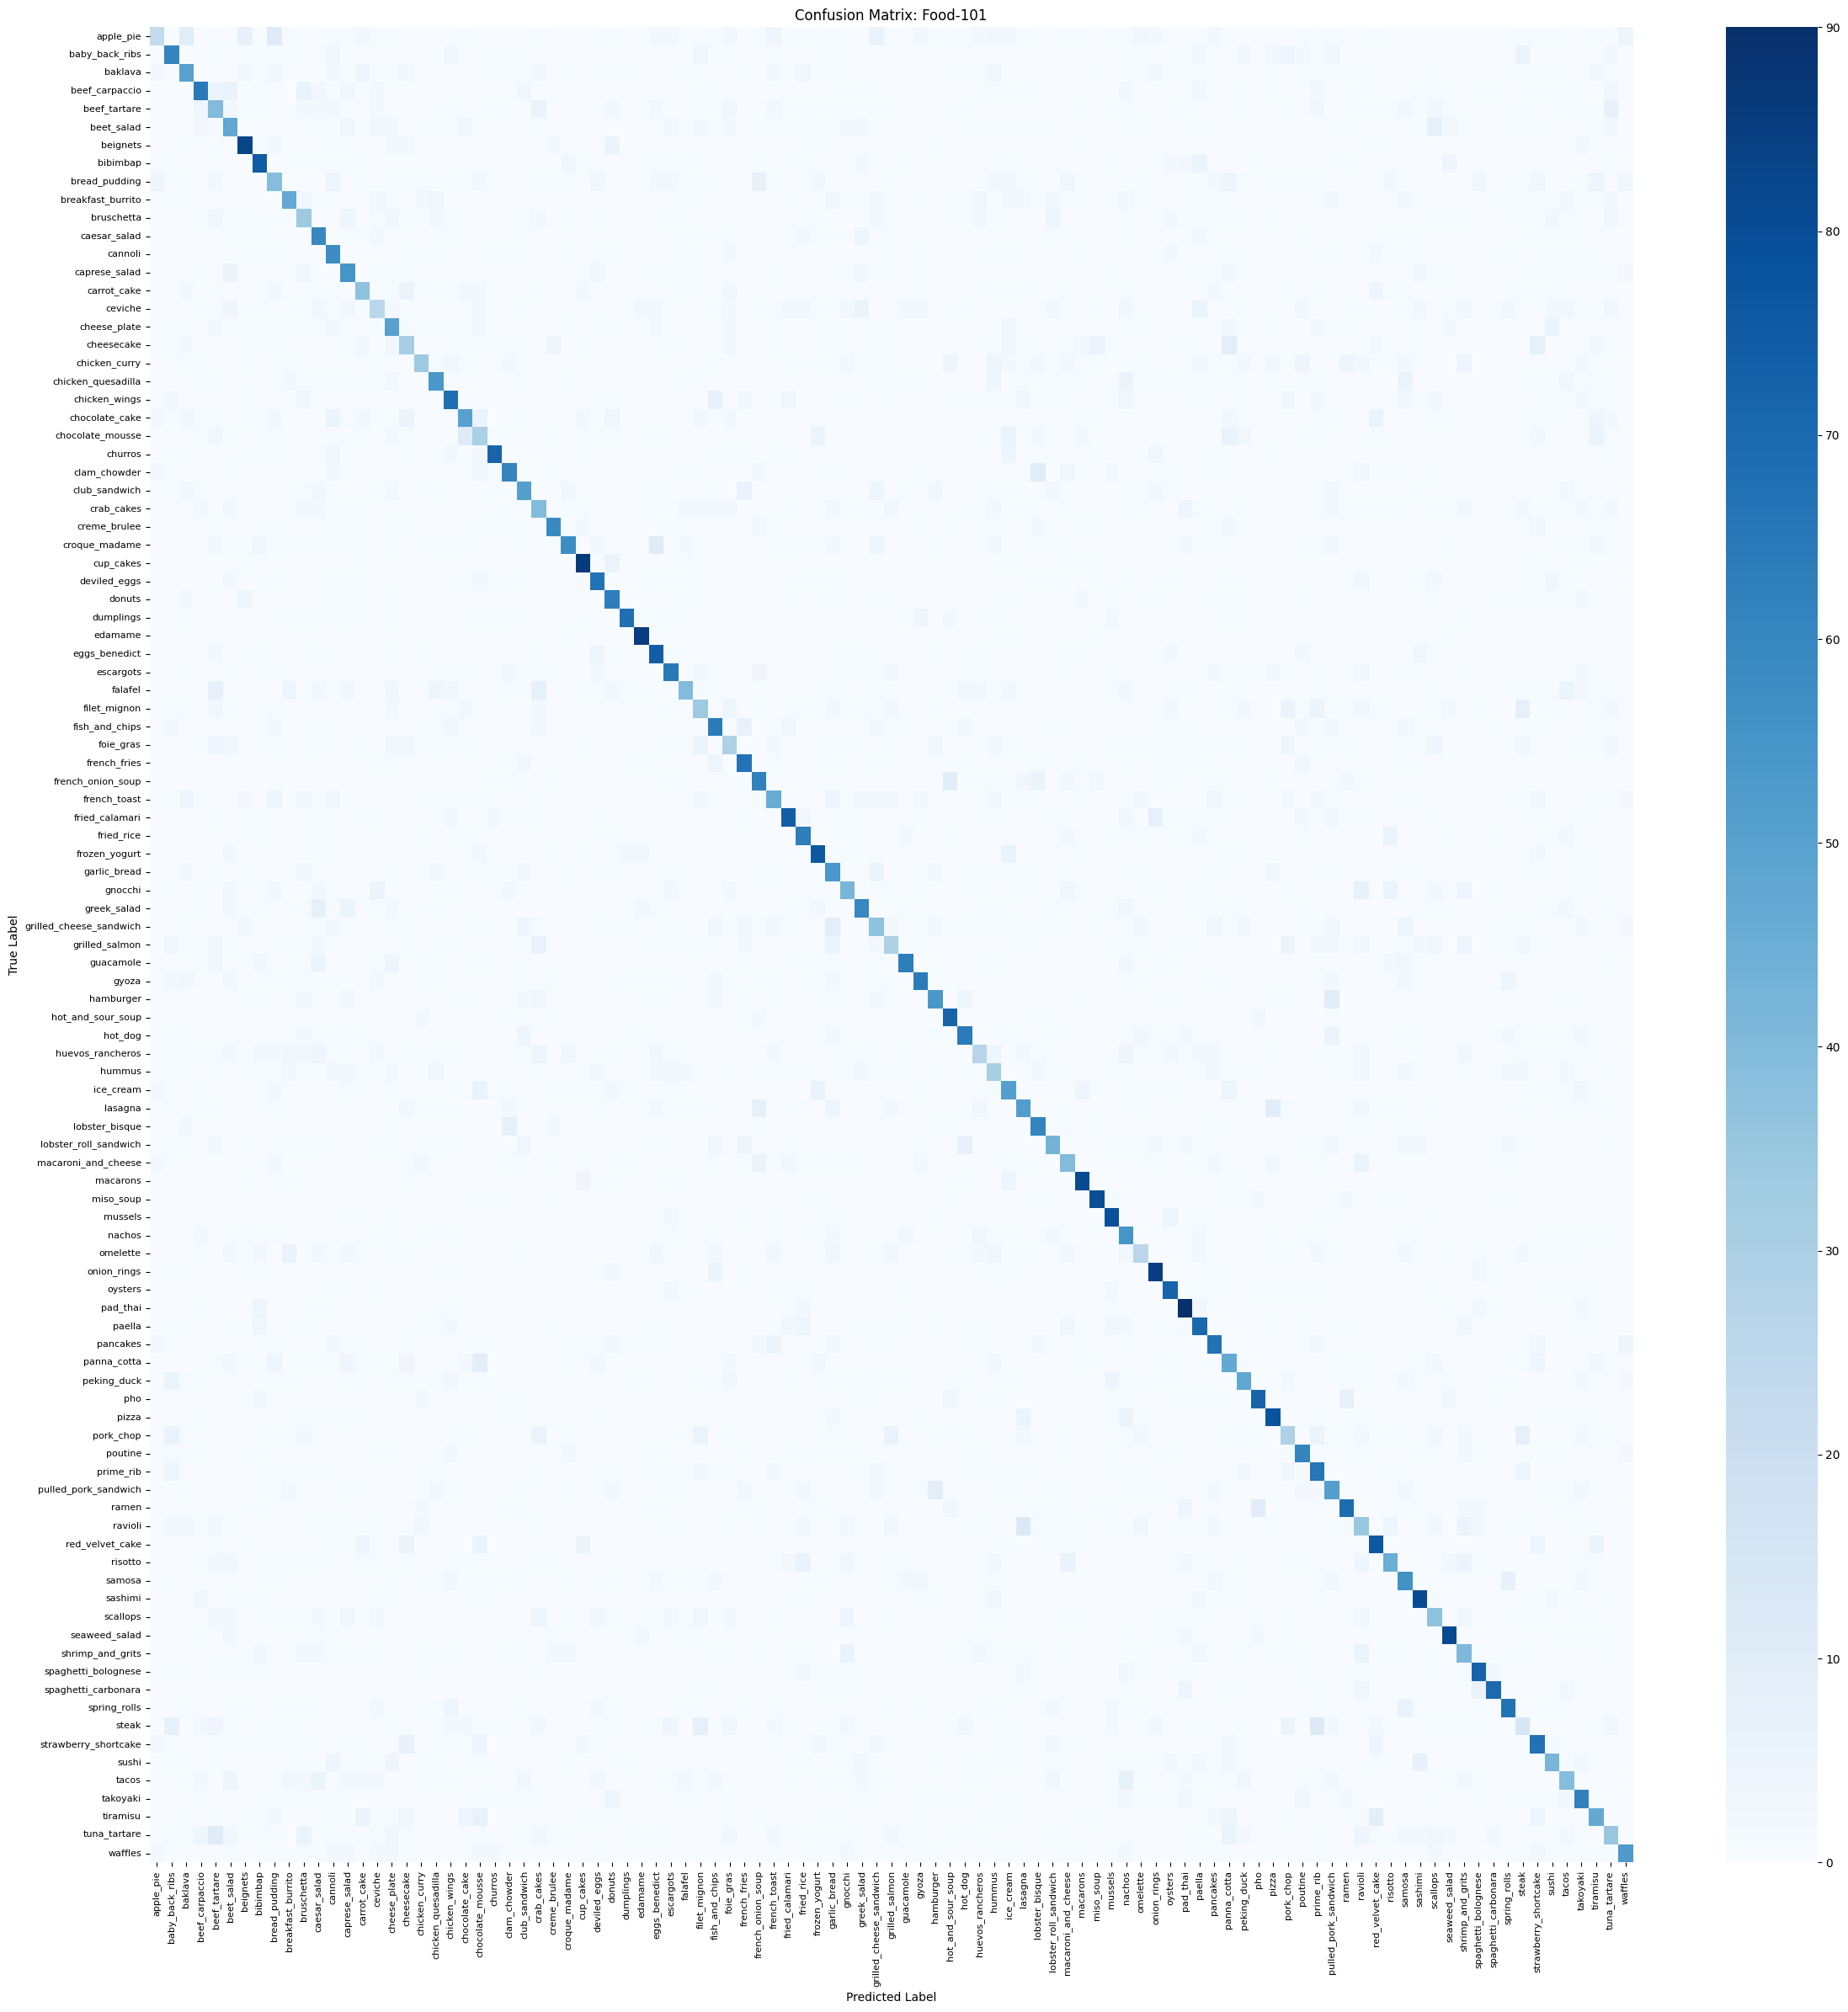

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, f1_score

# ฟังก์ชันประเมินผล (รับ model ที่โหลดมา)
def evaluate_saved_model(model, test_loader, class_names):
    print("Generating predictions on Test Set...")
    y_pred = []
    y_true = []
    
    model.eval() # สำคัญมาก! ต้องปิด Dropout/BatchNorm
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            y_pred.extend(preds.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    # --- 1. F1 Score ---
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n📊 Weighted F1-Score: {f1:.4f}")
    
    # --- 2. Classification Report ---
    print("\n📊 Classification Report (First 10 classes):")
    # labels=range(10) เพื่อให้แสดงแค่ 10 ตัวแรก (ถ้าอยากดูหมดให้ลบ parameter นี้ออก)
    print(classification_report(y_true, y_pred, target_names=class_names, labels=range(10), digits=4))

    # --- 3. Confusion Matrix ---
    print("\n📊 Plotting Confusion Matrix...")
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(24, 24)) 
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix: Food-101')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    plt.show()

# --- เรียกใช้งาน ---
# ต้องมั่นใจว่าตัวแปร test_loader และ class_names ยังอยู่ใน Memory นะครับ
evaluate_saved_model(model_eval, test_loader, class_names)

In [ ]:
evaluate_and_plot(trained_model, history, test_loader, class_names)
print("\n✅ All processes finished successfully!")